### Answers to Assignment 2 of 230E

##### Authors(alphabetic order)
1) Ishan Pathak ishan_pathak@berkeley.edu
2) Leonid Maksymenko leo.maksymenko@berkeley.edu
3) Nymph Qiu nymph_qiu@berkeley.edu
4) Xuanzhong Ren rxz19@berkeley.edu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Q1

#### (a)

Model satisfy the assumptions of the classical OLS models. Because classical OLS has more strict requirements, asymptotic OLS assumptions would also be satisfied.<br>
**Classical homoskedastic linear regression model** is good in this case given exogeneity, normality and homoskedasticity holds.<br>
1)Because $x,\epsilon \sim i.i.d.N(0,1)$, strict exogeneity holds. 
$$E(\epsilon|X)=0$$
2)And homoskedasticity of residuals holds given $\epsilon$ is i.i.d<br>
$\hat{\beta}$ is the best unbiased linear predictor.<br>
$$\hat{\beta}=(X'X)^{-1}X'y=\frac{\sum_{i=1}^T y_ix_i}{\sum_{i=1}^T x_i^2}$$
$$E(\hat{\beta}-\beta|X)=E((X'X)^{-1}X'\epsilon|X)=0$$
And it follows the distribution as below.
$$\hat{\beta} - \beta|X \sim N(0, \frac{1}{\sum_{i=1}^T x_i^2})$$
Theoretical standard error is $\frac{1}{\sqrt\sum_{i=1}^T x_i^2}$ given X. As for unconditional variance <br>
$$E((\hat{\beta} - \beta)^2)=E(((\hat{\beta} - \beta)^2|X))=E(\frac{1}{\sqrt\sum_{i=1}^T x_i^2})=\frac{1}{T-2}$$

#### (b)

In [14]:
N = 10000
Ts = [20, 50, 100, 500]
betas = {T: [] for T in Ts}
beta_vars = {T: [] for T in Ts}
for T in Ts:
    for i in range(N):
        X = np.random.normal(0,1,T).reshape(T,1)
        e = np.random.normal(0,1,T).reshape(T,1)
        y = X+e
        betas[T].append(np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)),X.T), y)[0,0])
        beta_vars[T].append(np.linalg.inv(np.dot(X.T, X))[0,0])

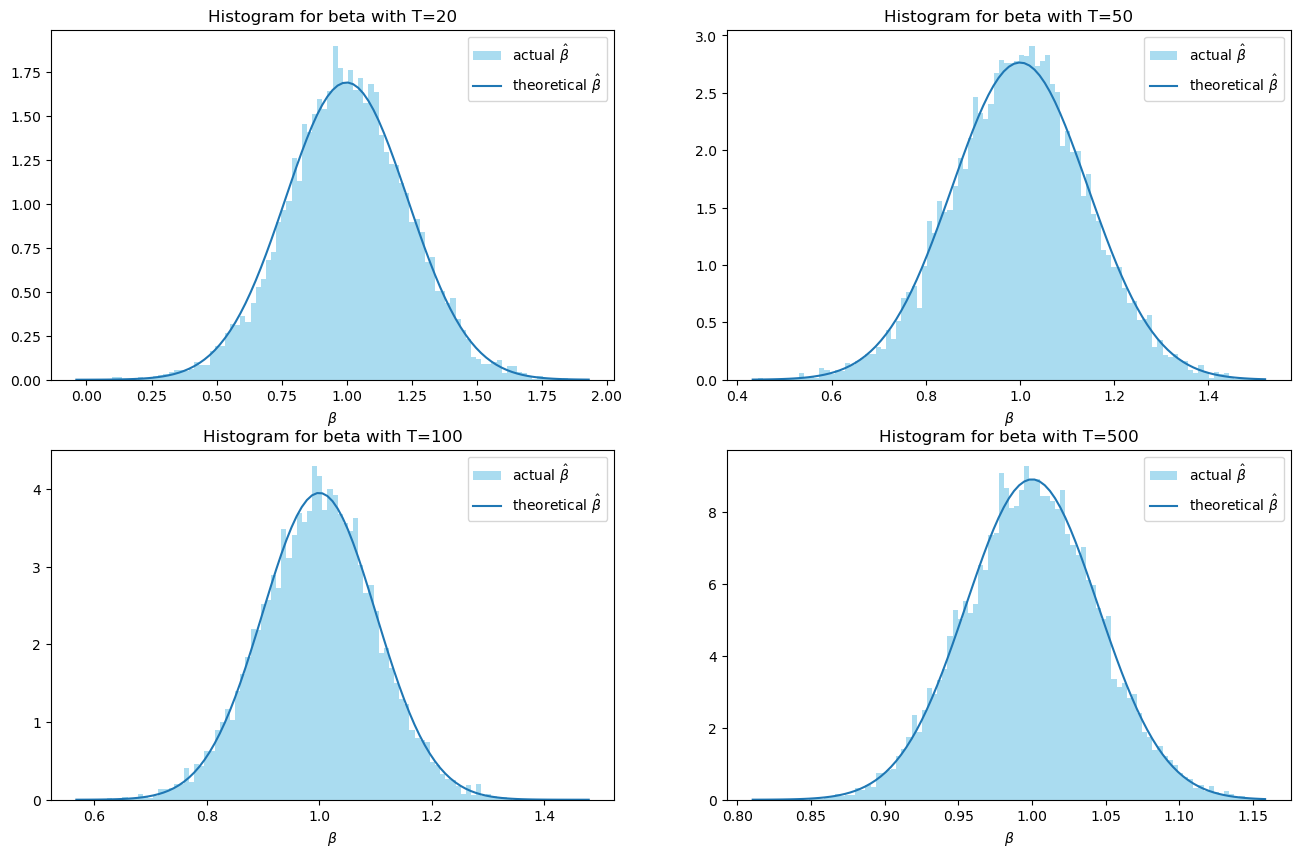

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
for i in range(4):
    T = Ts[i]
    n, bins, patches = axes[i//2,i%2].hist(betas[Ts[i]], 100, density = 1,color ='skyblue',alpha = 0.7, label=r'actual $\hat{\beta}$')
    expected_var = np.mean(beta_vars[Ts[i]])
    y_T = 1/np.sqrt(2*np.pi/(T-2))*np.exp(-(bins-1)**2/2*(T-2))
    axes[i//2,i%2].plot(bins, y_T, label=r'theoretical $\hat{\beta}$')
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_xlabel(r'$\beta$')
    axes[i//2,i%2].set_title(f'Histogram for beta with T={Ts[i]}')

We could observe that the actual distribution of $\hat{\beta}$ is close to theoretical normal distribution.

### Q2

#### (a)

In [16]:
import pandas_datareader.data as web
start = '1953-4-1'
today = '2020-2-29'
GS10 = web.DataReader(['GS10'], 'fred', start, today).resample('ME').last().dropna()

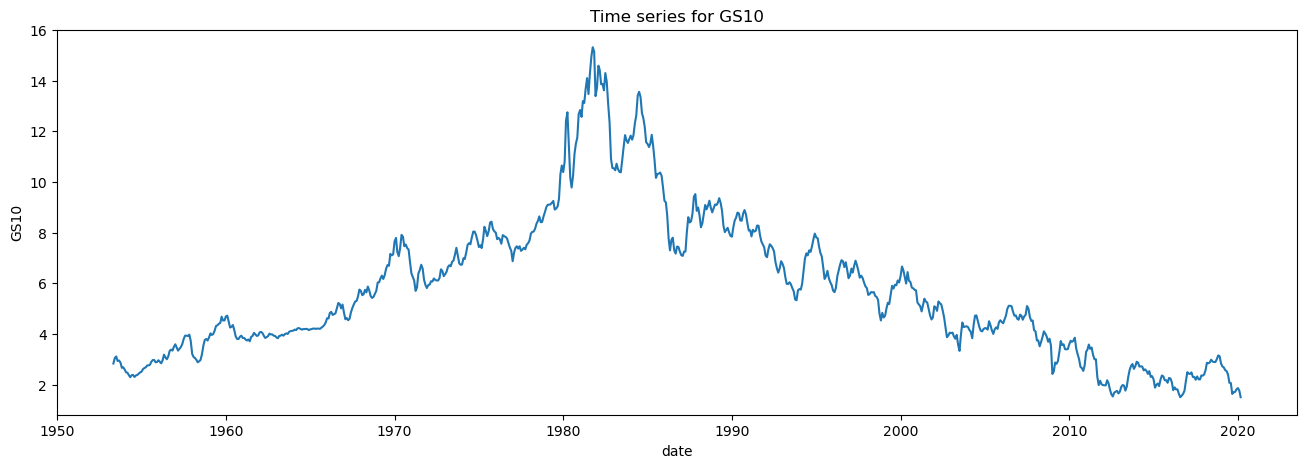

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(GS10["GS10"])
axes.set_xlabel("date")
axes.set_ylabel("GS10")
axes.set_title("Time series for GS10")
plt.show()

We could observe that the process is not stationary given there is little evidence for mean reversion.

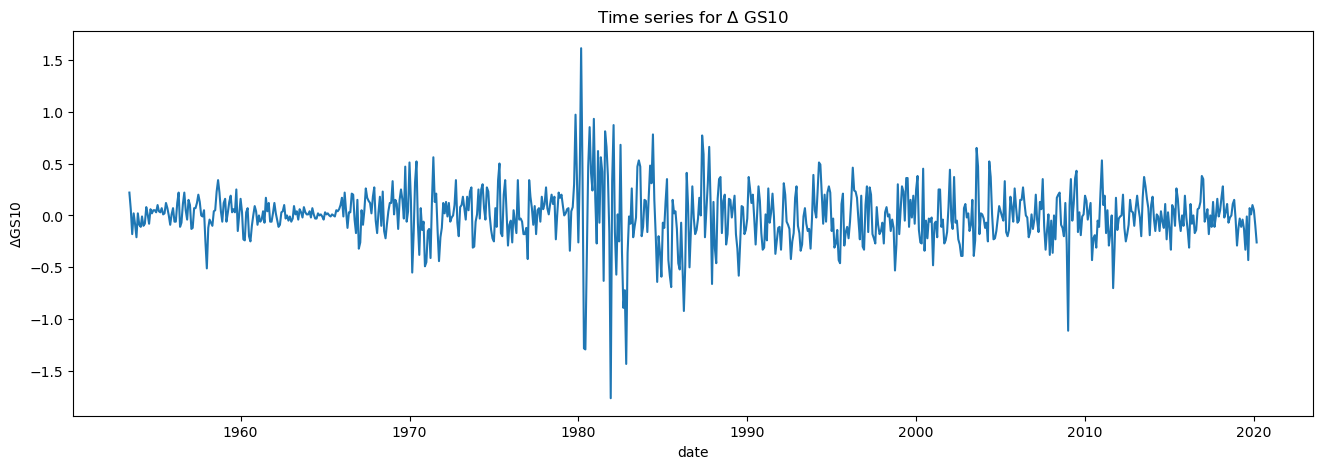

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(GS10.diff(periods=1))
axes.set_xlabel("date")
axes.set_ylabel(r'$\Delta$GS10')
axes.set_title(r'Time series for $\Delta$ GS10')
plt.show()

We could observe that GS10 differenced by lag 1 shows mean reversion. And due to oscillation scale varied by time, there is heteroskedasticity within the data.

#### (b)

In [469]:
def acf(y, lags=21):
    corrs = []
    for lag in range(lags):
        y_lag = y[:-lag] if lag > 0 else y
        cov = np.cov(y_lag, y[lag:])[1,0]
        corrs.append(cov/np.var(y))
    return corrs

def pacf(y, lags=21):
    y_lags = []
    coeffs = []
    # y = y - np.mean(y)
    for lag in range(lags):
        if lag == 0:
            coeffs.append(1)
            continue
        X = []
        for i in range(lag):
            X.append(y[i:len(y)-(lag-i)] if lag > 0 else y)
        X = np.array(X).T
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        coeffss = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)),X.T),(np.array(y[lag:])).reshape(len(y)-lag,1))
        coeffs.append(coeffss[1,0])
    return coeffs

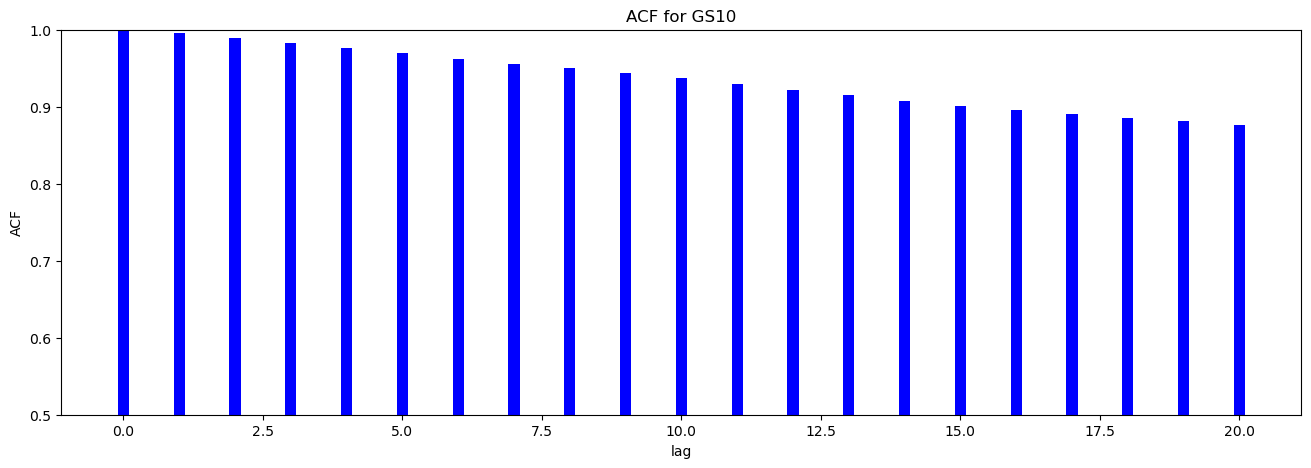

In [470]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.bar(list(range(21)), acf(list(GS10["GS10"])), color ='blue', 
        width = 0.2)
axes.axis(ymin=0.5,ymax=1.0)
axes.set_xlabel("lag")
axes.set_ylabel("ACF")
axes.set_title("ACF for GS10")
plt.show()

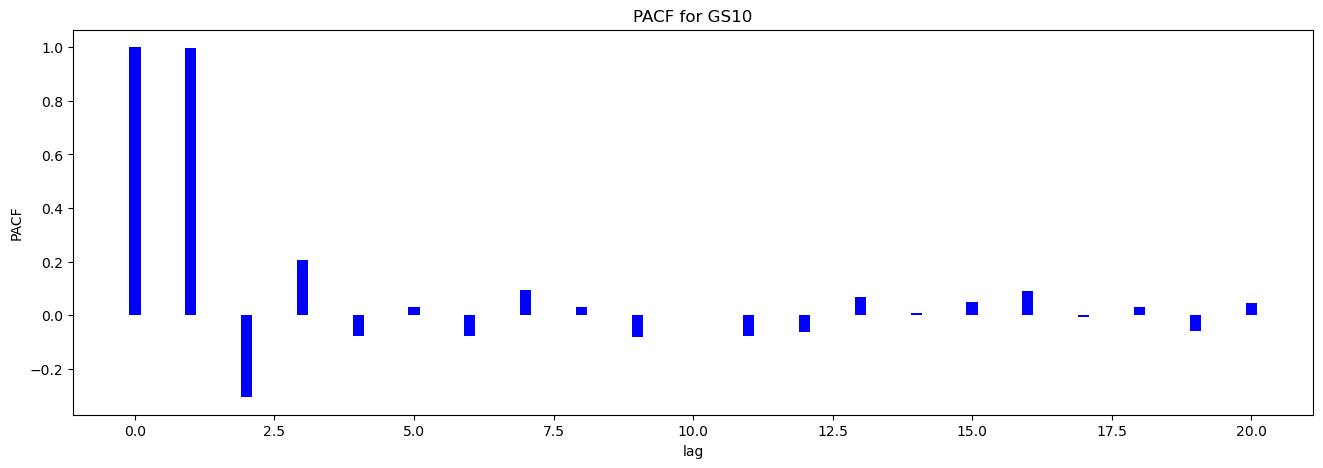

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.bar(list(range(21)), pacf(list(GS10["GS10"])), color ='blue', 
        width = 0.2)
axes.set_xlabel("lag")
axes.set_ylabel("PACF")
axes.set_title("PACF for GS10")
plt.show()

We could observe that the time series is not ergodic given ACF cannot die out for large lags so there is little chance for mean reversion and stationarity. As for PACF, we could see that large lags still persist, which further supports that data is not ergodic.

#### (c)

In [606]:
def calc_ols(y, lags=1):
    y_lags = []
    for i in range(lags):
        y_lags.append(y[i:len(y)-(lags-i)])
    y_lags = np.array(y_lags).T
    y_ = np.array(y[lags:]).reshape(len(y_lags),1)
    y_lags = np.concatenate((np.ones((len(y_lags), 1)), y_lags), axis=1)
    coef = np.dot(np.dot(np.linalg.inv(np.dot(y_lags.T, y_lags)),y_lags.T),y_)
    residual = y_ - np.dot(y_lags, coef)
    r_squared = np.sum((np.dot(y_lags, coef) - np.mean(y_))**2)/np.sum((y_ - np.mean(y_))**2)
    var = np.sum(residual**2)/(len(y_)-(lags+1))
    hetero_var = np.dot(y_lags.T, np.dot(np.diag(np.diag(np.dot(residual,residual.T))),y_lags))
    nw_var = hetero_var
    for i in range(lags):
        for j in range(i+1, len(y_)):
            part1 = y_lags[j].reshape(lags+1,1)
            part2 = y_lags[j-i-1].reshape(lags+1,1)
            nw_var = nw_var + 2*(1-(i+1)/(1+lags))*np.dot(part1, part2.T)*(residual[j][0]*residual[j-i-1][0])
    beta_homo_var = np.linalg.inv(np.dot(y_lags.T, y_lags))*var
    lhs = np.linalg.inv(np.dot(y_lags.T, y_lags))
    beta_hetero_var = np.dot(np.dot(lhs, hetero_var), lhs.T)
    beta_nw_var = np.dot(np.dot(lhs, nw_var), lhs.T)
    data = {"type": [],"coef":[], "homo_std":[],"hetero_std":[],"nw_std":[]}
    for i in range(lags+1):
        if i == 0:
            data["type"].append("mu")
        else:
            data["type"].append(f"phi{i}")
        data["coef"].append(coef[i,0])
        data["homo_std"].append(np.sqrt(beta_homo_var[i][i]))
        data["hetero_std"].append(np.sqrt(beta_hetero_var[i][i]))
        data["nw_std"].append(np.sqrt(beta_nw_var[i][i]))
    log_likelihood = -0.5*np.log(2*np.pi)*len(y_) - (len(y_)-(lags+1))/2 - 0.5 * len(y_) * np.log(var)
    AIC = -2*log_likelihood + 2 * (lags+1)
    BIC = -2*log_likelihood + np.log(len(y_)) * (lags+1)
    return pd.DataFrame(data=data), r_squared, AIC, BIC, log_likelihood

**AR(1) Model: $x_t = \mu + \phi_1x_{t−1} + \epsilon_t$**

In [611]:
params, r_squared, AIC, BIC, log_likelihood = calc_ols(GS10["GS10"], lags=1)
display(params)
display(pd.DataFrame(data={"type":["r^2","AIC","BIC","log likelihood"],"value":[r_squared,AIC, BIC, log_likelihood]}))

,type,coef,homo_std,hetero_std,nw_std
0,mu,0.018857,0.021046,0.026955,0.029968
1,phi1,0.996438,0.003272,0.005508,0.006175


,type,value
0,r^2,0.991446
1,AIC,149.386513
2,BIC,158.760730
3,log likelihood,-72.693256


**AR(2) Model:** $x_t = \mu + \phi_1x_{t−1} + \phi_2x_{t−2} + \epsilon_t$

In [612]:
params, r_squared, AIC, BIC, log_likelihood = calc_ols(GS10["GS10"], lags=2)
display(params)
display(pd.DataFrame(data={"type":["r^2","AIC","BIC","log likelihood"],"value":[r_squared,AIC, BIC, log_likelihood]}))

,type,coef,homo_std,hetero_std,nw_std
0,mu,0.027009,0.020106,0.026466,0.024823
1,phi1,-0.305585,0.033737,0.054676,0.045871
2,phi2,1.300634,0.033718,0.053560,0.044469


,type,value
0,r^2,0.992241
1,AIC,73.182454
2,BIC,87.240037
3,log likelihood,-33.591227


#### (d)

In [599]:
print("AR(1) root(s):", 1/0.996438)
print("AR(2) root(s):", \
      (1.300634 + np.sqrt(1.300634**2-4*0.305585))/2/0.305585,
     (1.300634 - np.sqrt(1.300634**2-4*0.305585))/2/0.305585
     )

AR(1) root(s): 1.0035747331996572
AR(2) root(s): 3.249006277435143 1.0072039423073185


AR(1): $x_t = 0.018857 + 0.996438x_{t−1} + \epsilon_t$. The root is 1.0035747331996572<br>
AR(2): $x_t = 0.027009 + 1.300634x_{t−1} -0.305585x_{t−2} + \epsilon_t$. The roots are 3.249006277435143 and 1.0072039423073185<br>

#### (e)

AR(1) IRF

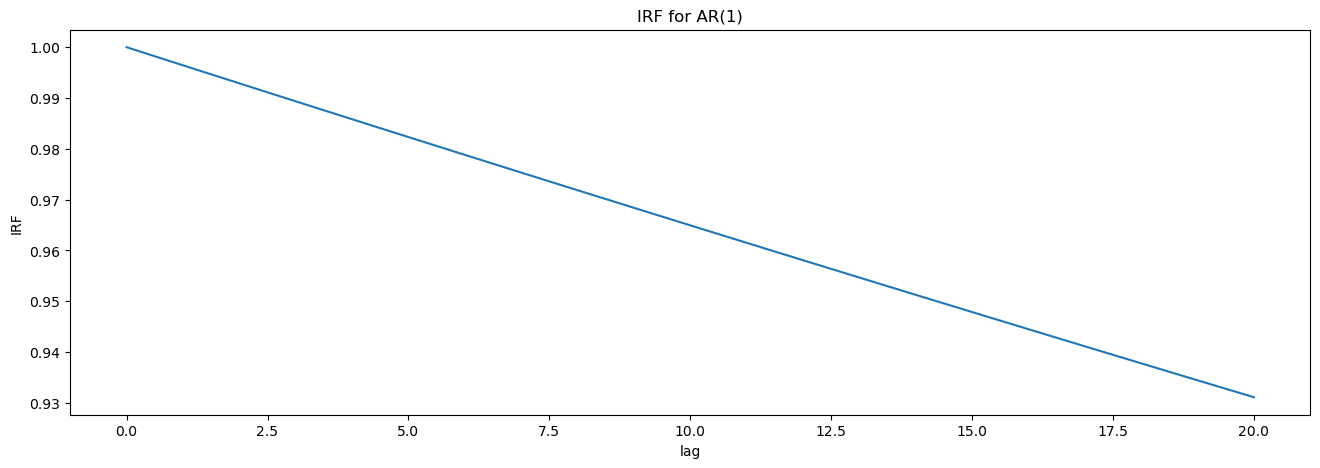

In [180]:
phi1 = 0.996438
irf_ar1 = [phi1**i for i in range(21)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(list(range(21)), irf_ar1)
axes.set_xlabel("lag")
axes.set_ylabel("IRF")
axes.set_title("IRF for AR(1)")
plt.show()

AR(2) model<br>
$x_t(1-\frac{1}{3.249006277435143}L)(1-\frac{1}{1.0072039423073185
}L)=0.027009 + \epsilon_t$<br>
$x_t=(0.027009 + \epsilon_t)(\frac{a}{1-\frac{1}{3.249006277435143}L}+\frac{b}{1-\frac{1}{1.0072039423073185
}L})$<br>
=>$a=-0.4492831176616153, b=1.4492831176616152$

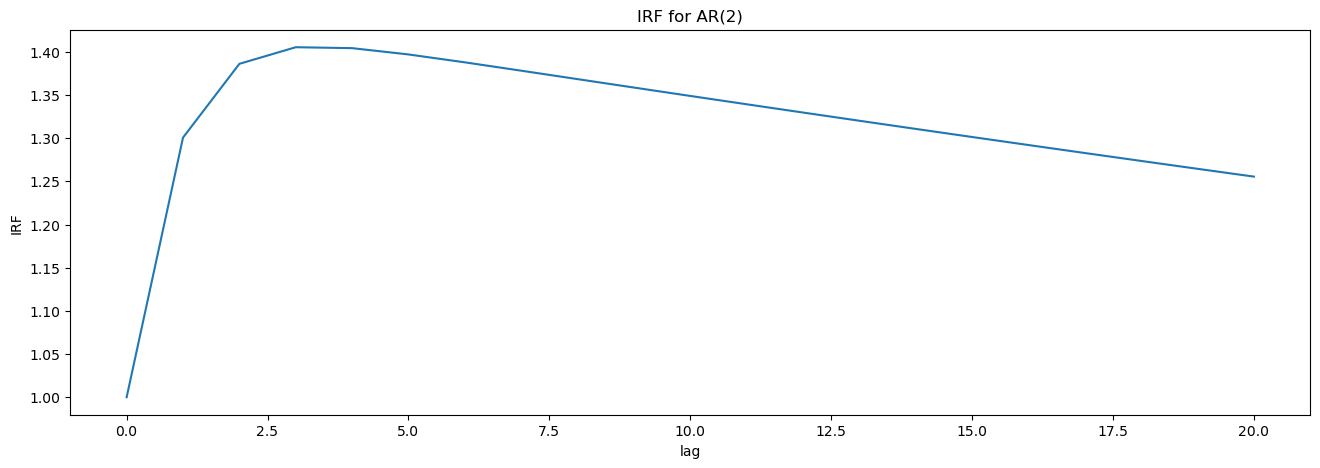

In [186]:
a = -0.4492831176616153
b = 1.4492831176616152
lambda1 = 1/3.249006277435143
lambda2 = 1/1.0072039423073185
irf_ar2 = [a*lambda1**i + b*lambda2**i for i in range(21)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(list(range(21)), irf_ar2)
axes.set_xlabel("lag")
axes.set_ylabel("IRF")
axes.set_title("IRF for AR(2)")
plt.show()

#### (f)

Based on AIC and BIC along with $R^2$, we could observe that AR(2) works better. And ACF shows high serial correlation between lags and it cannot die out for large lags which implies the need for more lags in the AR models.